In [47]:
import pennylane as qml
import tensorflow as tf
import sklearn.datasets
from sklearn.datasets import fetch_openml
import math
import numpy as np

from matplotlib import pyplot as plt

from tensorflow.keras.datasets import fashion_mnist

tf.keras.backend.set_floatx('float64')


## Load and reduce the data

Load the MNIST data and check number of training and test examples

In [48]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0  # add colour dimension

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


Create a function to filter out only 0 and 1

In [49]:
def filter_01(x, y):
    keep = (y == 0) | (y == 1)
    x, y = x[keep], y[keep]
    y = y == 0
    return x,y

In [50]:
x_train, y_train = filter_01(x_train, y_train)
x_test, y_test = filter_01(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 12665
Number of filtered test examples: 2115


Plot the original images

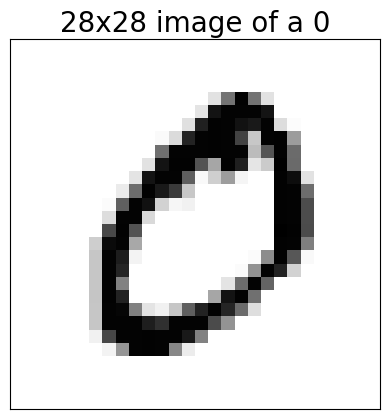

In [51]:
plt.imshow(x_train[0, :, :, 0], cmap='Greys')
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
plt.title("28x28 image of a 0", fontsize=20)
# save to file as pdf
plt.savefig('28x28_MNIST_0.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

Reduce images to 9x9

In [54]:
x_train_small = tf.image.resize(x_train, (28,28)).numpy()
x_test_small = tf.image.resize(x_test, (28,28)).numpy()

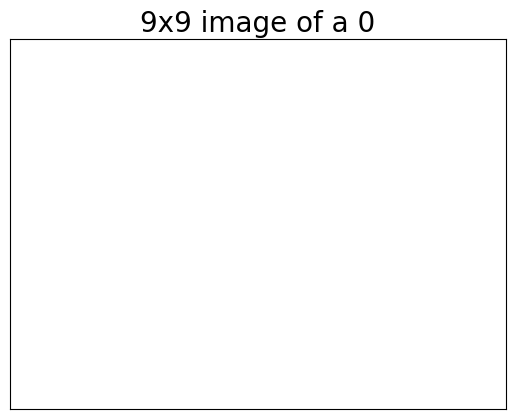

In [55]:
#plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1, cmap='Greys')
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
plt.title("9x9 image of a 0", fontsize=20)
# save to file as pdf
plt.savefig('9x9_MNIST_0.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

Further reduce images to 9x1

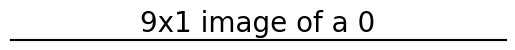

In [56]:
x_train_small = x_train_small[:,:,:,:].reshape((-1,784))  # take only central slices
x_test_small = x_test_small[:,:,:,:].reshape((-1,784))  # take only central slices

plt.imshow(x_train_small[0,:].reshape((1,-1)), vmin=0, vmax=1, cmap='Greys')
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
plt.title("9x1 image of a 0", fontsize=20)
# save to file as pdf
plt.savefig('9x1_MNIST_0.pdf', bbox_inches='tight', pad_inches=0)
plt.show()


## Set up the Quantum Neural Network

Create quantum circuit using pennylane qnode, then conver this to a Keras layer to make a Keras model

In [57]:
n_qubits = 11
n_layers = 2
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, diff_method="adjoint")

def qnode(inputs, weights):
    inputs= frqi(inputs)
    qml.AmplitudeEmbedding(inputs, wires = range(n_qubits), pad_with = 0.0, normalize = True, do_queue = True, id = None)


    for ii in range(n_qubits):
        qml.RY(np.pi * inputs[ii], wires = ii)

    for jj in range(n_layers):
        for ii in range(n_qubits - 1):
            qml.RZ(weights[jj, 2 * ii, 0], wires = 0)
            qml.RY(weights[jj, 2 * ii, 1], wires = 0)
            qml.RZ(weights[jj, 2 * ii, 2], wires = 0)

            qml.RZ(weights[jj, 2 * ii + 1, 0], wires = ii + 1)
            qml.RY(weights[jj, 2 * ii + 1, 1], wires = ii + 1)
            qml.RZ(weights[jj, 2 * ii + 1, 2], wires = ii + 1)

            qml.CNOT(wires = [ii + 1, 0])

        qml.RZ(weights[jj, 2 * (n_qubits - 1), 0], wires = 0)
        qml.RY(weights[jj, 2 * (n_qubits - 1), 1], wires = 0)
        qml.RZ(weights[jj, 2 * (n_qubits - 1), 2], wires = 0)

    return qml.expval(qml.PauliZ(0))


def frqi(inputarray):
    frqiarray = []
    for myinput in inputarray:
        frqiarray.extend([(1/math.sqrt(2))*np.cos(myinput), (1/math.sqrt(2))*np.sin(myinput)])
    return np.array(frqiarray)


weight_shapes = {'weights': (n_layers, 2 * (n_qubits - 1) + 1, 3)}
qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=1, name="quantumLayer")

inputs = tf.keras.Input(shape=(784,), name="inputs")
outputs = qlayer(inputs)
model = tf.keras.Model(inputs=inputs, outputs=outputs, name="QNN")

model.predict(x_train_small[0,:].reshape((1,-1)))
print(model.summary())

1/1 [==============================] - 1s 525ms/step
Model: "QNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 784)]             0         
                                                                 
 quantumLayer (KerasLayer)   (None, 1)                 114       
                                                                 
Total params: 114
Trainable params: 114
Non-trainable params: 0
_________________________________________________________________
None


Redefine the classification values to match the Hinge loss

In [58]:
y_train_hinge = 2.0*y_train-1.0
y_test_hinge = 2.0*y_test-1.0

Define the hinge accuracy

In [59]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

## Compile and train the model

Compile the model using the hinge loss and accuracy and the Adam optimiser

In [60]:
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

In [43]:
EPOCHS = 20
BATCH_SIZE = 32

NUM_EXAMPLES = 512 #x_train_small.shape[0]
print(NUM_EXAMPLES)

x_train_sub = x_train_small[:NUM_EXAMPLES,:]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

x_test_sub = x_test_small[:,:]
y_test_sub = y_test[:]



qnn_history_1layer = model.fit(
      x_train_sub, y_train_hinge_sub,
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      verbose=1)#,
      #validation_data=(x_test_sub, y_test_sub))

model.save('FASHION frq.h5')

qnn_results_1layer = model.evaluate(x_test_sub, y_test_sub)

512
Epoch 1/20
16/16 [==============================] - 244s 15s/step - loss: 0.9878 - hinge_accuracy: 0.5254
Epoch 2/20
16/16 [==============================] - 251s 16s/step - loss: 0.9855 - hinge_accuracy: 0.5254
Epoch 3/20
16/16 [==============================] - 245s 15s/step - loss: 0.9832 - hinge_accuracy: 0.5254
Epoch 4/20
16/16 [==============================] - 245s 15s/step - loss: 0.9814 - hinge_accuracy: 0.5254
Epoch 5/20
16/16 [==============================] - 244s 15s/step - loss: 0.9798 - hinge_accuracy: 0.5254
Epoch 6/20
16/16 [==============================] - 243s 15s/step - loss: 0.9779 - hinge_accuracy: 0.5254
Epoch 7/20
16/16 [==============================] - 245s 15s/step - loss: 0.9767 - hinge_accuracy: 0.5254
Epoch 8/20
16/16 [==============================] - 244s 15s/step - loss: 0.9753 - hinge_accuracy: 0.5254
Epoch 9/20
16/16 [==============================] - 251s 16s/step - loss: 0.9740 - hinge_accuracy: 0.5254
Epoch 10/20
16/16 [=======================

In [44]:
import pandas as pd

history_1l_df = pd.DataFrame(qnn_history_1layer.history)
with open('history_fashfrq.csv', mode = 'w') as f:
    history_1l_df.to_csv(f)

Create and train a 2 layer version of the QNN

## Plot the results!